## Livable streets App

In [12]:
%load_ext autoreload
%autoreload 2

In [60]:

import os
import json
import overpy
from shapely.geometry import Polygon, LineString, MultiPolygon, Point, mapping
from shapely.ops import polygonize, linemerge, unary_union

import folium

import geopandas as gpd

get_working_dir = os.getcwd()

## open geojson file

In [36]:
# open testing json file
city_name = 'Kreuzberg'

file_name= os.path.join(get_working_dir, 'data', f'{city_name}_nominatim.json')
f = open(file_name)
city_data = json.load(f)
osm_id = city_data['osm_id']
osm_id

In [39]:
minlat, maxlat, minlon, maxlon = city_data['boundingbox']
bbox = (minlat, minlon, maxlat, maxlon)
str(bbox).replace(' ', '')

"('52.4827923','13.3682291','52.5093816','13.4529296')"

# Get city boundaries

In [1]:
query_init = '[out:json][timeout:25];'
query_object = f'rel({osm_id});'
query_output = 'out body;>;out skel qt;'

# Get city boundaries
query = query_init + query_object + query_output
api = overpy.Overpass()
result = api.query(query)

NameError: name 'osm_id' is not defined

In [41]:
result.ways[0]

<overpy.Way id=97468190 nodes=[1129999579, 1152523581, 260647590, 3178025976, 3177794927, 3092557866, 3178025977, 3178025982]>

In [65]:
def nodes_to_multipolygons(result):
    line_list = []
    for way in result.ways:
        line_list.append(LineString([(node.lon, node.lat) for node in way.nodes]))
    merged_borders = unary_union(linemerge([*line_list]))
    polygons = polygonize(merged_borders)
    city = MultiPolygon(polygons)
    city_fix = city.buffer(0)
    buffer = city.buffer(0.004, join_style = 2, mitre_limit=2., cap_style=2)
    return [city_fix, buffer]

city_boundary_gdf = gpd.GeoDataFrame({'geometry': nodes_to_multipolygons(result), 'name': [city_name, f'{city_name}_buffer']},crs="EPSG:4326", geometry='geometry')    
city_boundary_gdf

,geometry,name
0,"POLYGON ((13.36858 52.49396, 13.36841 52.49448...",Kreuzberg
1,"POLYGON ((13.36442 52.49473, 13.36447 52.49528...",Kreuzberg_buffer


In [58]:
city_boundary_gdf.to_file(f'{get_working_dir}/data/{city_name}_boundary.gpkg', driver='GPKG', layer='name')  


## plotting on folium

In [61]:
map_test = folium.Map(width=750,
                      height=500,
                      location=[
                          city_boundary_gdf.geometry[0].centroid.y,#lat
                          city_boundary_gdf.geometry[0].centroid.x,#lon
                      ],
                      tiles="openstreetmap",
                      zoom_start=13)

folium.GeoJson(city_boundary_gdf.geometry[0]).add_to(map_test)
folium.GeoJson(city_boundary_gdf.geometry[1]).add_to(map_test)

In [62]:
map_test

---

## Deprecated method, for loops

In [50]:
lss = []
for ii_w, way in enumerate(result.ways):
    ls_coords = []

    for node in way.nodes:
        ls_coords.append(
            (node.lon, node.lat))  # create a list of node coordinates

    lss.append(
        LineString(ls_coords))  # create a LineString from coords

merged = linemerge([*lss])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
city = MultiPolygon(polygons)




---

## Getting information with request and overpass API

In [44]:

import requests

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
                [out:json][timeout:25];
                rel({osm_id});
                out geom;
                """
response = requests.get(overpass_url, 
                            params={'data': overpass_query})
res = response.json()

In [45]:
res['elements'][0]['bounds']

{'minlat': 52.4827923,
 'minlon': 13.3682291,
 'maxlat': 52.5093816,
 'maxlon': 13.4529296}

In [46]:
way = res['elements'][0]['members'][1]
# way['geometry']
way

{'type': 'way',
 'ref': 97602691,
 'role': 'outer',
 'geometry': [{'lat': 52.4941678, 'lon': 13.4446428},
  {'lat': 52.494545, 'lon': 13.4451616},
  {'lat': 52.494856, 'lon': 13.4455486},
  {'lat': 52.4948401, 'lon': 13.446909},
  {'lat': 52.4948733, 'lon': 13.4474502},
  {'lat': 52.4967182, 'lon': 13.4500551},
  {'lat': 52.4970891, 'lon': 13.4506551},
  {'lat': 52.4972687, 'lon': 13.4510076},
  {'lat': 52.4973922, 'lon': 13.4513876},
  {'lat': 52.4975232, 'lon': 13.452013},
  {'lat': 52.4977068, 'lon': 13.4529296}]}

In [47]:
node = res['elements'][0]['members'][0]['geometry'][0]
tupl = (node['lon'], node['lat'])
tupl

(13.4396363, 52.4899002)

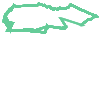

In [49]:
lss = []  #convert ways to linstrings
ls_coords = []

for way in res['elements'][0]['members']:
    if way.get('geometry') != None:
        for node in way.get('geometry'):
            ls_coords.append((node['lon'], node['lat'])) # create a list of node coordinates
    if LineString(ls_coords) != None:
        lss.append(LineString(ls_coords)) # create a list of linestrings

lss

# shapely.geometry.linestring.LineString

# type(lss[1])
# print(type(lss[1]) == type(geometry.LineString()))
# geometry.LineString(lss[1])
merged = linemerge([*lss]) #merge linestrings
merged